# Problem 4 - 1

3.2.4 Problem 4: Your Best Bidding Strategy (10/30 marks)
- Find a more optimal model
- The model you developed can be tested over the validation set.
- Explain your approach and discuss your results in the individual report. 
- This does include, but is not limited to, reporting the performance metrics of your solution + the parameter turning results on the validation set.
- Your bidding strategy described here may be part of the more complex model for the group, see problem 5 below, which will be tested over the test dataset.
- Some directions: A non-linear bidding strategy (e.g. ORTB) [2], a lift-based bidding [3] or using other CTR estimators.


## SETUP

In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score,f1_score
sys.path.append("../Code/")
from utils import *
import xgboost
from strategies import ortb_bidding_strategy

## DATA LOAD

In [2]:
# data directory
DATA_DIR = os.path.join('..', 'Data')

In [3]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [4]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

In [5]:
from scipy.sparse import csr_matrix
train_X_encoded = csr_matrix(train_X) 
valid_X_encoded = csr_matrix(valid_X)
test_X_encoded = csr_matrix(test_X)

In [6]:
print ("Train shape:", train_X_encoded.shape, "Valid shape:", valid_X_encoded.shape, "Test shape:", test_X_encoded.shape)

Train shape: (2430981, 823) Valid shape: (303925, 823) Test shape: (303375, 823)


for i in relevant_columns:
    print(i,len(set(train_X[i])))

## BUILD FIRST MODEL TO ESTIMATE CTR

price_model = xgboost.XGBRegressor(max_depth=10, n_estimators=100, random_state=0,
                        max_delta_step=1, objective='reg:linear', learning_rate=0.1, 
                        scale_pos_weight=1)

price_model.fit(train_X_encoded, np.log1p(train_y.payprice), eval_metric="rmse",  
          eval_set=[(valid_X_encoded, np.log1p(valid_y.payprice))],
          verbose=True, early_stopping_rounds=10)

### Grid Search CV

In [9]:
from sklearn.grid_search import GridSearchCV
def gridsearch_cv(features, labels):
    
    clf = xgboost.XGBRegressor(
        eval_metric = 'logloss',
        objective='binary:logistic',
        n_jobs = 8,
        silent = 1,
        max_delta_step=0,
        )
    
    parameters = {
        'n_estimators': [75, 100],
        'learning_rate': [0.1, 0.3],
        'max_depth': [4, 10],
    }
    clf = GridSearchCV(clf, parameters, n_jobs=8, cv=2)
    
    clf.fit(features, labels)
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters

In [10]:
gridsearch_cv(train_X_encoded, train_y['click'])

score: 0.1364447613457356
learning_rate: 0.1
max_depth: 10
n_estimators: 100


{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

### Training Model

In [7]:
xgb_model = xgboost.XGBRegressor(max_depth=10, n_estimators=100, random_state=0, n_jobs=8,
                        max_delta_step=0, objective='binary:logistic', learning_rate=0.1,
                        scale_pos_weight=1)

xgb_model.fit(train_X_encoded, train_y['click'], eval_metric="logloss", eval_set=[(valid_X_encoded, valid_y['click'])], verbose=True, early_stopping_rounds=300)

#print(xgb_model.score(train_X_encoded, train_y['click']))

[0]	validation_0-logloss:0.598384
Will train until validation_0-logloss hasn't improved in 300 rounds.
[1]	validation_0-logloss:0.520776
[2]	validation_0-logloss:0.456061
[3]	validation_0-logloss:0.401365
[4]	validation_0-logloss:0.354645
[5]	validation_0-logloss:0.314405
[6]	validation_0-logloss:0.279511
[7]	validation_0-logloss:0.249064
[8]	validation_0-logloss:0.222391
[9]	validation_0-logloss:0.198929
[10]	validation_0-logloss:0.178224
[11]	validation_0-logloss:0.159899
[12]	validation_0-logloss:0.143636
[13]	validation_0-logloss:0.129173
[14]	validation_0-logloss:0.116289
[15]	validation_0-logloss:0.104794
[16]	validation_0-logloss:0.094524
[17]	validation_0-logloss:0.085333
[18]	validation_0-logloss:0.077098
[19]	validation_0-logloss:0.069716
[20]	validation_0-logloss:0.063093
[21]	validation_0-logloss:0.057147
[22]	validation_0-logloss:0.051804
[23]	validation_0-logloss:0.047
[24]	validation_0-logloss:0.04268
[25]	validation_0-logloss:0.038792
[26]	validation_0-logloss:0.035294


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
xgb_model_75 = xgboost.XGBRegressor(max_depth=10, n_estimators=75, random_state=0, n_jobs=8,
                        max_delta_step=0, objective='binary:logistic', learning_rate=0.3,
                        scale_pos_weight=1)

xgb_model_75.fit(train_X_encoded, train_y['click'], eval_metric="logloss", eval_set=[(valid_X_encoded, valid_y['click'])], verbose=True, early_stopping_rounds=300)

#print(xgb_model.score(train_X_encoded, train_y['click']))

[0]	validation_0-logloss:0.438146
Will train until validation_0-logloss hasn't improved in 300 rounds.
[1]	validation_0-logloss:0.297329
[2]	validation_0-logloss:0.208606
[3]	validation_0-logloss:0.149299
[4]	validation_0-logloss:0.108284
[5]	validation_0-logloss:0.079336
[6]	validation_0-logloss:0.058627
[7]	validation_0-logloss:0.043682
[8]	validation_0-logloss:0.032831
[9]	validation_0-logloss:0.024917
[10]	validation_0-logloss:0.019142
[11]	validation_0-logloss:0.014917
[12]	validation_0-logloss:0.011827
[13]	validation_0-logloss:0.009573
[14]	validation_0-logloss:0.007936
[15]	validation_0-logloss:0.006742
[16]	validation_0-logloss:0.00587
[17]	validation_0-logloss:0.005257
[18]	validation_0-logloss:0.004813
[19]	validation_0-logloss:0.004507
[20]	validation_0-logloss:0.004292
[21]	validation_0-logloss:0.004153
[22]	validation_0-logloss:0.004044
[23]	validation_0-logloss:0.003979
[24]	validation_0-logloss:0.003937
[25]	validation_0-logloss:0.003906
[26]	validation_0-logloss:0.0038

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=75,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [68]:
valid_pred = xgb_model.predict(valid_X_encoded)

In [9]:
valid_pred_75 = xgb_model_75.predict(valid_X_encoded)

In [13]:
train_pred = xgb_model.predict(train_X_encoded)

In [10]:
train_pred_75 = xgb_model_75.predict(train_X_encoded)

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_y.click, valid_pred)

0.8937508375841289

#### Base Bid Optimization

In [11]:
def base_bid_optimization(min_val, max_val, n, preds, true):

    base_bid = np.linspace(min_val, max_val, n)
    clicks = np.zeros_like(base_bid)

    for i, bb in zip(range(n), base_bid):
        bids = bb*preds
        _, c, _, _, _, _, _ = new_performance(bids, true, verbose=False)
        clicks[i] = c
    plt.plot(base_bid, clicks)
    plt.show()

    # best result
    print("Best number of clicks:", np.max(clicks))
    print("Best base bid:", base_bid[np.argmax(clicks)])
    return base_bid[np.argmax(clicks)]

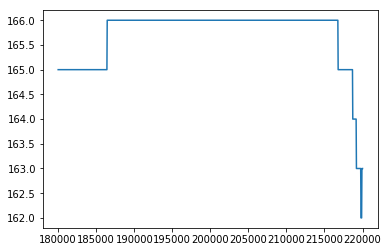

Best number of clicks: 166.0
Best base bid: 186446.44644644644


In [12]:
best_75 = base_bid_optimization(180000, 220000, 1000, valid_pred_75, valid_y)

In [18]:
bids = 186446.44644644644*valid_pred_75
_, c, _, _, _, _, _ = new_performance(bids, valid_y)

               CTR: (0.1547)%
        num_clicks: 166
             spend: 5511132 (88.18)%
              aCPM: 18.1331973348688
              aCPC: 33.19959036144578
num_in_budget_wins: 107292
 ads_within_budget: 303925


In [209]:
bids = best_75*valid_pred_75
_, c, _, _, _, _, _ = new_performance(bids, valid_y)

               CTR: (0.1269)%
        num_clicks: 164
             spend: 5777031 (92.43)%
              aCPM: 19.008080941
              aCPC: 35.2257987805
num_in_budget_wins: 129239
 ads_within_budget: 303925


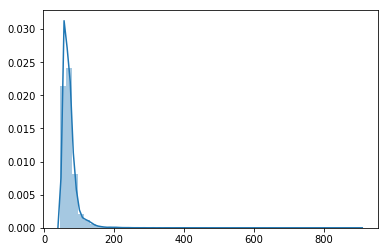

In [239]:
import seaborn as sns 
sns.distplot(example_x)
plt.show()

In [240]:
np.median(example_x)

67.260487365571564

### ORTB Strategy

### bid Pay Evaluation

In [92]:
bid_pay = [[a,b] for a, b in zip(example_x, valid_y.payprice)]

In [51]:
np.median(valid_pred)

0.00032617259

In [52]:
np.mean(valid_pred)

0.00071288284

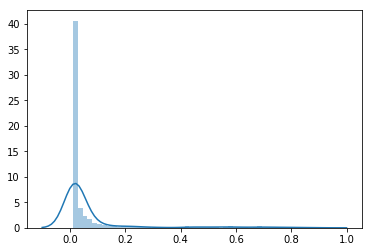

In [72]:
import seaborn as sns
sns.distplot(valid_pred[valid_pred>0.01])
plt.show()

In [93]:
bid_pay

[[54.43961865193932, 23],
 [49.61701115759351, 75],
 [54.399686787810857, 65],
 [57.707279254674944, 6],
 [50.666799795406767, 5],
 [80.855800075902721, 22],
 [78.43616195419682, 31],
 [76.088239982400083, 20],
 [72.690879864777699, 58],
 [40.261419842271401, 55],
 [81.650069923159478, 88],
 [55.386721279608039, 55],
 [48.262019875896449, 49],
 [85.300333110130794, 110],
 [79.571219180369553, 160],
 [47.819533116286401, 16],
 [70.308634657630463, 50],
 [66.464851466019113, 76],
 [73.303035034072465, 89],
 [72.02489938581283, 136],
 [58.896230077661464, 55],
 [85.529168383139989, 50],
 [73.725713936207086, 64],
 [54.479063831879039, 129],
 [81.112618944280442, 20],
 [60.756512776967433, 166],
 [49.635628585375599, 88],
 [88.980114927408238, 221],
 [75.856575324347361, 69],
 [104.69548024198525, 70],
 [56.721064791072664, 20],
 [63.414335720670095, 18],
 [65.35749466430552, 114],
 [79.47945089970186, 33],
 [85.453770069614677, 126],
 [67.474392883182759, 66],
 [83.516799898933371, 133],


In [224]:
lmda = np.linspace(5e-7, 1, 100)
c_val = np.linspace(0.1, 100, 100)
clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))

for i, lm in zip(range(len(lmda)), lmda):
    for j, cv in zip(range(len(c_val)), c_val):
        bids = ortb_bidding_strategy(valid_pred*100000, cv, lm, 2)
        _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
        clicks[i, j] = c


In [225]:
lmi, cvi = np.unravel_index(clicks.argmax(), clicks.shape)

In [226]:
lmda[lmi]

0.010101505050505052

In [227]:
c_val[cvi]

9.1818181818181817

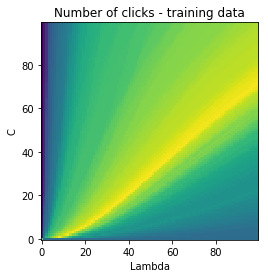

In [111]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - training data")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(clicks, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

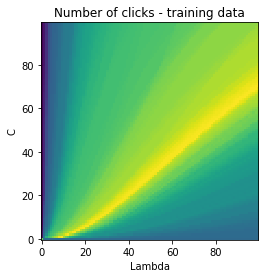

In [238]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - training data")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(clicks, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

In [ ]:
### 75 model 0.3

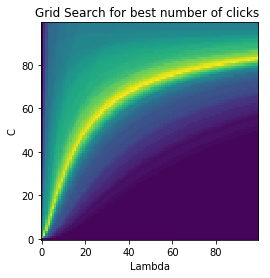

In [52]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Grid Search for best number of clicks ")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(c, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

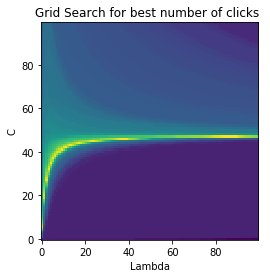

In [36]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Grid Search for best number of clicks ")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(c, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

## ortb 1 = best results

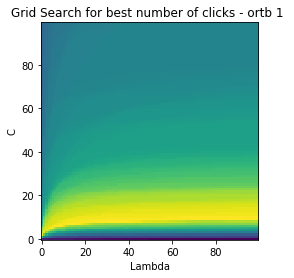

In [55]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Grid Search for best number of clicks - ortb 1 ")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(c, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

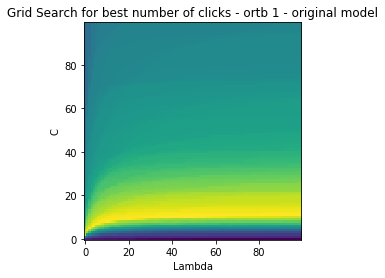

In [82]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Grid Search for best number of clicks - ortb 1 - original model")
ax.set_xlabel("Lambda")
ax.set_ylabel("C")
#plt.xticks
plt.imshow(c, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

In [28]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred_75*100000, 151.414141, 1.767681e-01, 1)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.1368)%
        num_clicks: 167
             spend: 6098493 (97.58)%
              aCPM: 20.0657826766472
              aCPC: 36.51792215568862
num_in_budget_wins: 122118
 ads_within_budget: 303925


(0.13675297662916194,
 167,
 6098493,
 20.0657826766472,
 36.51792215568862,
 122118,
 303925)

### Save Model

In [10]:
import pickle as pkl
pkl_filename = '../lynray_xgb100_aws.pkl'
with open(pkl_filename, 'wb') as file:  
    pkl.dump(xgb_model, file)

In [ ]:
### Prepare Submission

In [20]:
submission = pd.read_csv('../Data/Group_xx.csv')

In [21]:
submission.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,0.0
1,29167d4caa719788b5a342dbaa25151d53121f80,0.0
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,0.0
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,0.0
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,0.0


In [23]:
test_predictions = 186446.44644644644*xgb_model_75.predict(test_X_encoded)

In [24]:
submission.bidprice = test_predictions

In [25]:
submission.to_csv('../Group_01_xgbbb_75.csv')

### Extra

In [32]:
def join_table(data, newData, rowLen, colLen):
    for col in newData.keys():
        data = data.join(pd.DataFrame({col: [newData[col][r, c] for r in range(rowLen) for c in range(colLen)]}).reset_index(drop=True))
    return data

In [33]:
def analysis_table(pred, y, params, t, budget=6250*1000):
    start = time.time()
    lmda_range = params[0]
    c_val_range = params[1]
    clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CTR = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    spend = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CPM = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    eCPC = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    winrate_a = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    budget_lifetime = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    
    params = {'lamda': [lmda_range[l] for l in range(len(lmda_range)) for _ in range(len(c_val_range))],
              'c' : [c_val_range[c] for _ in range(len(lmda_range)) for c in range(len(c_val_range))]}
    vals = pd.DataFrame(params).reset_index(drop=True)

    for i, lm in zip(range(len(lmda_range)), lmda_range):
        for j, cv in zip(range(len(c_val_range)), c_val_range):
            bids = ortb_bidding_strategy(pred, cv, lm, t)
            CTR[i,j], clicks[i, j], s, CPM[i, j], eCPC[i, j], wins, imps  = new_performance(bids, y, budget=budget, verbose=False)
            spend[i,j] = 100*s/budget
            winrate_a[i,j] = wins*100/imps
            budget_lifetime[i,j]= imps*100/len(y)
    cols = {'CTR': CTR,
            'clicks': clicks,
            'spend%': spend,
            'aCPM': CPM,
            'eCPC': eCPC,
            'win%': winrate_a,
            'lifetime%': budget_lifetime}
    vals = join_table(vals, cols, len(lmda_range), len(c_val_range))

    print("time spent:- {0:.2f} seconds".format(time.time()-start))
    return vals, clicks

In [37]:
lmda = np.linspace(5e-7, 2.5, 100)
c_val = np.linspace(0.1, 10000, 100)

In [38]:
a,c = analysis_table(valid_pred_75*100000, valid_y, [lmda, c_val], 2)

time spent:- 1122.25 seconds


In [35]:
a.sort_values(by='clicks', ascending=False)

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
4211,1155.555556,2.121212e+00,0.094569,153.0,99.999568,20.748589,40.849497,53.709532,99.111294
4109,954.545455,2.070707e+00,0.094525,152.0,98.304080,20.215530,40.421086,52.909106,100.000000
4788,8894.444444,2.373738e+00,0.093607,152.0,99.968480,20.557802,41.105461,53.427984,100.000000
4789,8994.949495,2.373738e+00,0.094161,152.0,99.999776,20.863330,41.118329,53.886263,98.566423
4638,3869.191919,2.323233e+00,0.093745,151.0,98.581536,20.272587,40.803616,52.998273,100.000000
4417,1758.585859,2.222222e+00,0.094892,151.0,96.506672,19.845906,39.944815,52.357654,100.000000
4784,8492.424242,2.373738e+00,0.096369,151.0,93.898480,19.309550,38.865265,51.555482,100.000000
4313,1356.565657,2.171717e+00,0.095725,151.0,95.026304,19.541479,39.332079,51.902279,100.000000
4785,8592.929293,2.373738e+00,0.095595,151.0,95.260352,19.589609,39.428954,51.972691,100.000000
4786,8693.434343,2.373738e+00,0.094770,151.0,96.720400,19.889858,40.033278,52.425105,100.000000


In [ ]:
# ortb 1 

In [81]:
a.sort_values(by='clicks', ascending=False)

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
1146,474.646465,2.777782e-01,0.125884,162.0,90.605968,18.632469,34.956006,42.342683,100.000000
1173,747.373737,2.777782e-01,0.123952,162.0,93.504208,19.228471,36.074154,43.002714,100.000000
1171,727.171717,2.777782e-01,0.124044,162.0,93.356896,19.198177,36.017321,42.970799,100.000000
1170,717.070707,2.777782e-01,0.124095,162.0,93.271360,19.180587,35.984321,42.953031,100.000000
1169,706.969697,2.777782e-01,0.124148,162.0,93.186640,19.163165,35.951636,42.934606,100.000000
1168,696.868687,2.777782e-01,0.124191,162.0,93.120480,19.149560,35.926111,42.919799,100.000000
1167,686.767677,2.777782e-01,0.124251,162.0,93.013840,19.127630,35.884969,42.899070,100.000000
1166,676.666667,2.777782e-01,0.124299,162.0,92.935776,19.111577,35.854852,42.882619,100.000000
1165,666.565657,2.777782e-01,0.124358,162.0,92.864544,19.096929,35.827370,42.862219,100.000000
1164,656.464646,2.777782e-01,0.124427,162.0,92.766864,19.076841,35.789685,42.838529,100.000000
